<a href="https://colab.research.google.com/github/FishyDanny/Road-Safety-Risk-Prediction/blob/main/05_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
import joblib
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# Load data
X_test = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/y_test.pkl')

# Load models
with open('/content/drive/MyDrive/ACTL3143_project/models/final_baseline_rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

dl_models = {
    'Feedforward NN': keras.models.load_model('/content/drive/MyDrive/ACTL3143_project/models/final_first_dl_model.keras'),
    'Residual NN': keras.models.load_model('/content/drive/MyDrive/ACTL3143_project/models/final_second_dl_model.keras')
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_type='baseline'):
  if model_type == 'baseline': # evaluate baseline differently as it uses sklearn instead of keras
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
  else:
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_proba = model.predict(X_test).flatten()

  return {
      'classification_report': classification_report(y_test, y_pred, target_names=['Single', 'Multiple'], output_dict=True),
      'auc': roc_auc_score(y_test, y_proba),
      'accuracy': np.mean(y_pred == y_test),
      'f1': f1_score(y_test, y_pred),
      'confusion_matrix': confusion_matrix(y_test, y_pred)
  }

results = {
    'Random Forest': evaluate_model(rf_model, X_test, y_test, model_type='baseline'),
}

for model_name, model in dl_models.items():
  results[model_name] = evaluate_model(model, X_test, y_test, 'deep learning')

359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
comparison_data = []
for model_name, metrics in results.items():
    cr = metrics['classification_report']
    comparison_data.append({
        'Model': model_name,
        'F1-Score': metrics['f1'],
        'AUC-ROC': metrics['auc'],
        'Precision (Single)': cr['Single']['precision'],
        'Recall (Single)': cr['Single']['recall'],
        'Precision (Multiple)': cr['Multiple']['precision'],
        'Recall (Multiple)': cr['Multiple']['recall'],
        'Accuracy': cr['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data).set_index('Model')
print("Model Performance Comparison:")
display(comparison_df.style.format("{:.4f}"))

Model Performance Comparison:


,F1-Score,AUC-ROC,Precision (Single),Recall (Single),Precision (Multiple),Recall (Multiple),Accuracy
Model,,,,,,,
Random Forest,0.7058,0.8062,0.7754,0.6971,0.6666,0.7500,0.7207
Feedforward NN,0.6748,0.8005,0.7344,0.7652,0.6933,0.6573,0.7170
Residual NN,0.6789,0.7987,0.7380,0.7636,0.6941,0.6643,0.7192


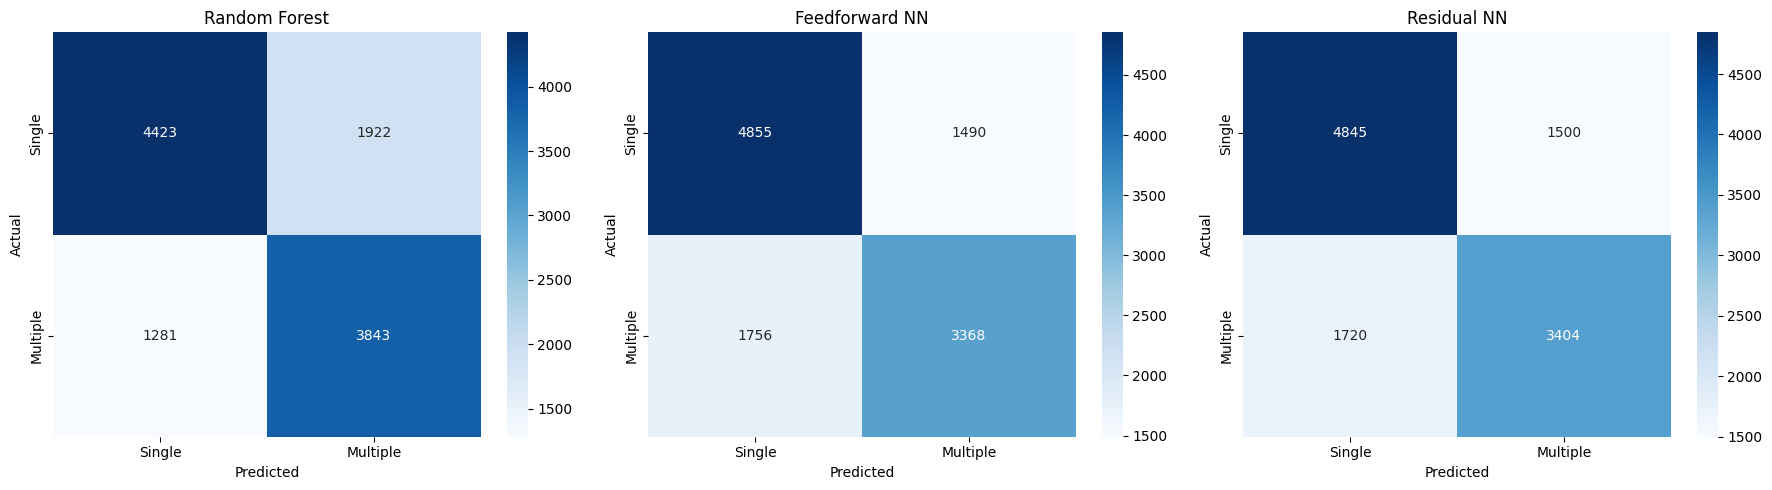

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model_name, metrics) in zip(axes, results.items()):
    sns.heatmap(metrics['confusion_matrix'],
                annot=True, fmt='d',
                cmap='Blues',
                xticklabels=['Single', 'Multiple'],
                yticklabels=['Single', 'Multiple'],
                ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()